# Deep Solver for American Options

## 1.Market Model

Consider the price $X$ of our underlying follows the Black-Scholes dynamics
$$ \mathrm{d}X_t=X_t(r+\lambda) \mathrm{d}t + \sigma X_t \mathrm{d}W_t, \qquad t \in [0,T] $$
where $W$ is a one-dimensional Brownian Motion.

We assume that 

- $T=5$,
- $X_0=1$,
- $r=0$,
- $\lambda = 0$ (in order to directly work with the EMM),
- $\sigma = 1$ for convenience.

We hence have $X_t=\exp(-\frac{1}{2}t+W_t), t \in [0,T]$. To simulate this process, we set up a function to compute the Euler-Maruyama discretization of a realization:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# set seed
torch.manual_seed(777)

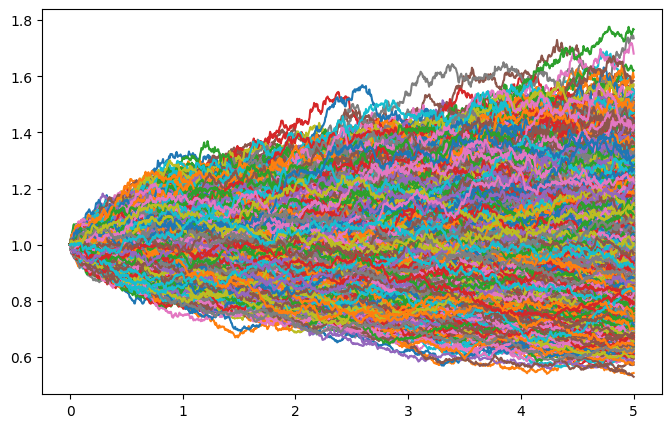

In [2]:
# Setting up Euler-Maruyama for this Example

def mu(s,mu=0):
    return(mu*s)

def sigma(s, sigma=1):
    return(sigma*s)

def euler_maruyama(mu,sigma,x_0,T,n,N):
    # x_0 = starting point of the process
    # T = time horizon
    # n = number of steps
    # N = number of simulations
    time_grid = np.linspace(0,T,n+1)
    x = np.random.normal(loc = 0, scale = T/n, size = (n,N))
    x = np.vstack([x_0*np.ones((1,N)),x])
    h = T/n # stepsize
    for i in range(1,n+1): # Euler-Maruyama discretization
        x[i,] = x[i-1,] + mu(x[i-1,])*h+sigma(x[i-1,])*x[i,]
    return x

# generate a sample

x_0 = 1
T = 5
n = 1000
N = 10000

data = euler_maruyama(mu,sigma,x_0,T,n,N)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,5,1001),data)
plt.show()

## 2. Price Process of the American Put

Let $g(x)=(K-x)_{+}$ be the payoff function of a vanilla American put option with strike price $K$ We assume $K=0.9$. We want to compute the price of such an option, written on our underlying $X$, at time $t \in [0,T]$ and assuming the underlying is currently trading at $X_t=x$. Since we are already working with an EMM and in a discounted market(see above), the risk neutral price (?) in this case is given by
$$
V(t,x)=\sup\limits_{\tau \in \Tau} \mathbb{E}[g(X^{t,x}_\tau)],
$$
where $\Tau$ is the set of all $[t,T]$-valued stopping times and $X^{t,x}$ is a process in the time interval $[t,T]$ that starts at $X^{t,x}_t=x$ and follows the same dynamics as our initial process $X$.

We know that $V(s,X^{t,x}_s)=Y^{t,x}_s, s \in [t,T]$, where $Y^{t,x}$ is the solution of the RBSDE 

$$ Y^{t,x}_s = g\bigl(X^{t,x}_T\bigr) - \int_t^s Z^{t,x}_r \mathrm{d} W_r + K^{t,x}_T - K^{t,x}_s,\quad s\in[t,T]$$

satisfying the constraints

$$ Y^{t,x} \geq g\bigl(X^{t,x}\bigr)\quad\text{ on }[t,T]
  \qquad\text{and}\qquad
  \int_t^T Y^{t,x}_s - g\bigl(X^{t,x}_s\bigr)\mathrm{d} K_s = 0.$$

A solution of this RBSDE consists of a triplet $(Y^{t,x},Z^{t,x},K^{t,x})$ of processes defined on $[t,T]$ such that $Y^{t,x}$ is continuous and adapted with values in $\mathbb{R}$, $Z^{t,x}$ is predictable with values in $\mathbb{R}$, $K^{t,x}$ is continuous, increasing, adapted with $K^{t,x}_t = 0$ and values in $\mathbb{R}_+$, and finally they satisfy the integrability condition

$$ \mathbb{E} \Bigl[\sup_{s\in[t,T]}|Y^{t,x}_s|^2 + \int_t^T \|Z^{t,x}_s\|^2\mathrm{d} s + |K^{t,x}_T|^2\Bigr] < \infty. $$

In the subsequent, assume $t=0$ and $x=1=X_0$. Then $V(s,X^{0,1}_s)=Y^{0,1}_s, s \in [0,5]$.


In [3]:
d = 1 # dimension of the spatial variable

K = 0.9 #strike price

# define payoff of the American put
def g(x):
    return torch.max(K-x, torch.tensor(0.0))[...,1].unsqueeze(-1)

## 3. Approximating $V$ with a Neural Network

### 3.1 Setting up the Neural Network

We want to approximate $V$ via neural networks $\{\hat{V}^\theta:\theta\in\Theta\}$.

To try this out, we set up a corresponding neural network with following properties:

- 3 hidden layers à 10 hidden units
- sigmoid activation function for the 3 hidden layers

In [4]:
# define neural network
class NeuralNet(nn.Module):
    def __init__(self, input=1+d, h1=10, h2=10, h3=10, output=1): # constructor method to initialize the parameters of the network, 
                                                                  # define the layers, etc. (see TUM LOOP)
        # Input = (t,x) -> hidden layer 1 (h1 hidden units) -> hidden layer 2 (h2 hidden units) -> hidden layer 3 (h3 hidden units) -> output = V(t,x) 
        super(NeuralNet, self).__init__() # What is the purpose of this?
        self.fc1 = nn.Linear(input, h1) # linear combinations from input to hidden layer 1
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3,output)

    # define how an input moves forward through the net, esp. define the activation functions for the single layers (see Hastie et al.)
    def forward(self, x): # What does the "self" mean?

        # Apply each layer
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.out(x)

        return x

### 3.2 Setting up the Loss Function

- Now, we want to train this neural network with the simulated Euler-Maruyama data from above.

- Problem: Find an adequate loss function.

- First guess: $L(\theta) = \mathbb{E}\Bigl[ |V^\theta (T,\bar{X}_T)-g(\bar{X}_T)|^2 \Bigr] + \sum\limits_{i=0}^{N-1} \mathbb{E}\Bigl[ | V^\theta(t_n,\bar{X}_{t_i}) - \max \lbrace m_i(\bar{X}_{t_{i+1}}),g(\bar{X}_{t_i})\rbrace |^2 \Bigr]$, where $\bar{X}$ is the Euler-Maruyama discretization with stepsize $h=\frac{T}{n}$ and $m_i(x) := \mathbb{E}[ V(t_{i+1},x+\mu (x)h+\sigma (x)A)]$ where $A \sim \mathcal{N}(0,h)$.

- In order to work with our `data` array of Euler-Maruyama trajectories (shape=(10000,1001)), we will transform it into a **PyTorch tensor** of shape (100,100,1001,2). We do this in such a way that we end up with 100 batches, each containing 100 Euler-Maruyama samples of shape (1001,2) (c.f. the construction of the `data` array with 10000 samples of Euler-Maruyama discretizations with 1001 time points each).

- The idea is the following: The loss function should take 1 batch as input to use the 100 sampled trajectories inherited in the single batch to approximate the expectations 

In [5]:
# check if Apple GPU is available for more computation power

if torch.backends.mps.is_available():
    print("MPS (Apple GPU) is available!")
else:
    print("MPS is not available.")

# switch to Apple GPU

device = torch.device("cpu")

MPS (Apple GPU) is available!


In [6]:
# transforming the training data

training_sets = np.zeros((100,100,n+1,2))

training_sets[:,:,:,0] = np.linspace(0,T,n+1)

for i in range(100):
    for j in range(100):
        training_sets[i,j,:,1] = data[:,i*100+j]

training_sets = torch.tensor(training_sets, requires_grad=True) # requires_grad=true, so that the loss function can compute the gradients of $V$ if needed
training_sets = training_sets.float() # necessary at some step... (forgot to document where)

# setting up the function m_i(x)

def m(x,i,V): 
    A = ((T/n)**(1/2))*torch.randn(100).to(device) # 100 samples of the rv A
    x_inp = x + mu(x)*(T/n) + sigma(x)*A # 100 samples of x + mu(x)*h + sigma(x)*A 
    t_inp = (torch.ones(100)*(i+1)*(T/n)).to(device) # 1D tensor of length 100 that contains t_{i+1} in each entry
    values = torch.vstack((t_inp,x_inp)).t() # (100,2)-shaped tensor where each row is a sample of (t_{i+1},x + mu(x)*h + sigma(x)*A)

    return V(values).squeeze().mean() # mean of the deduced 100 samples of V(t_{i+1},x + mu(x)*h + sigma(x)*A)


# define loss (important: use PyTorch operations)

# the input should have the shape (100,1001(=n+1),2(=(t,x))), where 100 is the number of generated Euler-Maruyama 
# trajectories we put into the loss function at once

def loss_fct(input,model):
    output = model(input).squeeze(-1) # tensor of shape (100,1001) where output[i,j] = model(input[i,j,:])
    loss = ((output[:,-1]-g(input[:,-1,1]))**2).mean() # approximation of the first expecatation in the loss functional
    for i in range(n):
        # computation of the i-th summand of the sum inherited in the loss function
        X = input[:,i+1,1] # 1D tensor of length 100 with the samples of X^pi_{t_{i+1}}
        m_tensor = torch.tensor([m(X[i], i, model) for i in range(X.shape[0])]) # 1D tensor of length 100 with the respective samples of m_i(X^pi_{t_{i+1}})
        m_tensor = m_tensor.to(device)
        loss += ((output[:,i]-torch.max(g(X),m_tensor))**2).mean() # approximation of the expectation in the i-th summand
    return(loss)

### 3.3 Training the Neural Network 

In [8]:
# instantiate the model
model = NeuralNet()

# move training data to device

training_sets = training_sets

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(20):
    for i in range(10):
        sample = training_sets[i]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Compute the custom loss
        loss = loss_fct(sample, model)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

    # Print loss every 10 epochs
    #  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")

Epoch: 0, Loss: 15.7621
Epoch: 1, Loss: 0.0188
Epoch: 2, Loss: 0.0540
Epoch: 3, Loss: 0.0745
Epoch: 4, Loss: 0.0849
Epoch: 5, Loss: 0.0908
Epoch: 6, Loss: 0.0949
Epoch: 7, Loss: 0.0985
Epoch: 8, Loss: 0.1020
Epoch: 9, Loss: 0.1058
Epoch: 10, Loss: 0.1098
Epoch: 11, Loss: 0.1142
Epoch: 12, Loss: 0.1189
Epoch: 13, Loss: 0.1240
Epoch: 14, Loss: 0.1295
Epoch: 15, Loss: 0.1353
Epoch: 16, Loss: 0.1416
Epoch: 17, Loss: 0.1482
Epoch: 18, Loss: 0.1553
Epoch: 19, Loss: 0.1627


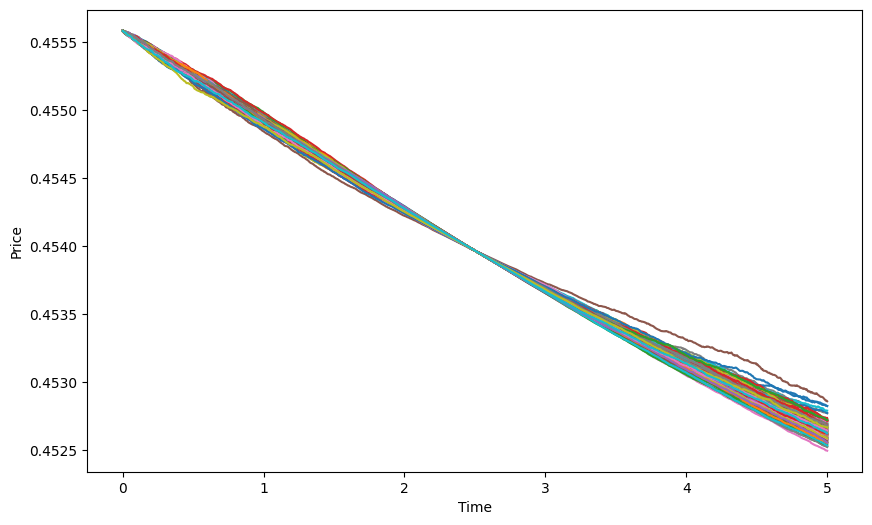

In [9]:
timegrid = np.linspace(0,T,n+1)
price_paths = model(training_sets[0]).squeeze().detach().numpy()

plt.figure(figsize=(10, 6))

for i in range(100):
    plt.plot(timegrid, price_paths[i,:])

plt.xlabel('Time')
plt.ylabel('Price')
plt.show()